### Project 5: Time Series Forecasting for Stock Prices

## Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

2025-08-26 20:30:51.178989: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 20:30:51.316620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 20:30:51.442860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756240251.553300    4165 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756240251.586459    4165 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756240251.821993    4165 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 690.5 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 KB 189.7 kB/s eta 0:00:001m172.7 kB/s eta 0:00:01


## Step 2: Load Stock Data

We can use yfinance to fetch stock price data (e.g., Apple).

In [13]:
!pip install yfinance


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 KB 149.8 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 KB 479.7 kB/s eta 0:00:001m469.5 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 KB 767.0 kB/s eta 0:00:001.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 KB 433.1 kB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 KB 722.4 kB/s eta 0:00:00 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 114.4 kB/s eta 0:00:00m eta 0:00:010:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.2/161.2 KB 327.0 kB/s eta 0:00:001m354.4 kB/s eta 0:00:01
  Created wheel for multitasking: filen

In [14]:
import yfinance as yf

# Download Apple stock data
df = yf.download("AAPL", start="2018-01-01", end="2023-01-01")

print(df.head())


/tmp/ipykernel_4165/101696173.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.380997  40.390375  39.677740  39.888719  102223600
2018-01-03  40.373959  40.917812  40.310668  40.444285  118071600
2018-01-04  40.561501  40.664645  40.338803  40.446634   89738400
2018-01-05  41.023312  41.110045  40.566195  40.657619   94640000
2018-01-08  40.870937  41.166304  40.772478  40.870937   82271200


## Step 3: Visualize Closing Prices

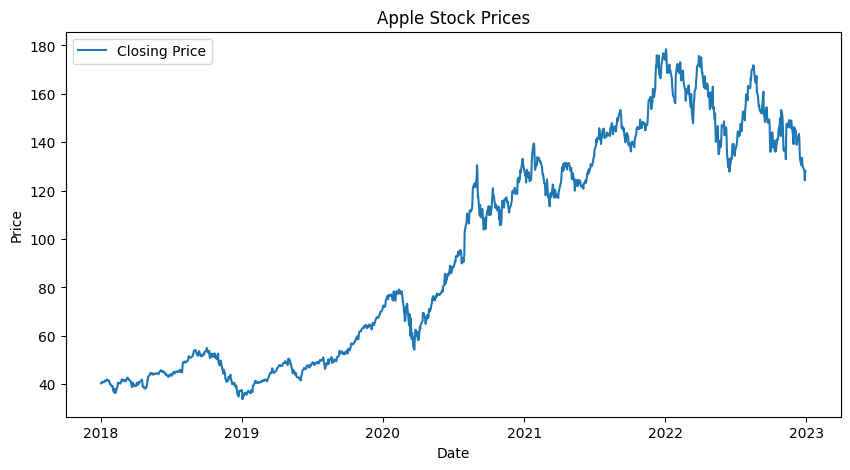

In [15]:
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label="Closing Price")
plt.title("Apple Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## Part A: ARIMA Forecasting
## Step 4A: Check Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.0638028263380488
p-value: 0.7292890311812091


### 👉 If p-value < 0.05 → data is stationary. Otherwise, we difference it.

## Step 5A: Fit ARIMA Model

In [17]:
# Fit ARIMA(p,d,q)
model = ARIMA(df['Close'], order=(5,1,0))  # example parameters
model_fit = model.fit()
print(model_fit.summary())


/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1259
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2757.375
Date:                Tue, 26 Aug 2025   AIC                           5526.750
Time:                        20:41:32   BIC                           5557.574
Sample:                             0   HQIC                          5538.334
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0597      0.020     -2.975      0.003      -0.099      -0.020
ar.L2         -0.0290      0.020     -1.438      0.150      -0.069       0.011
ar.L3         -0.0312      0.022     -1.388      0.1

## Step 6A: Forecast

/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


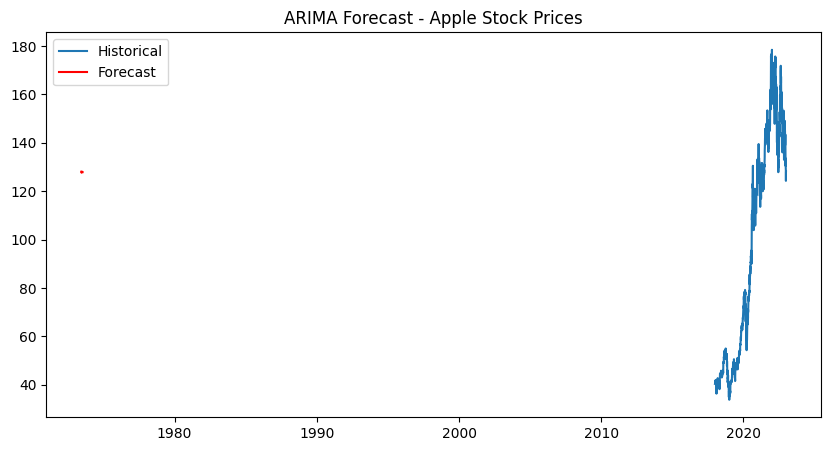

In [18]:
forecast = model_fit.forecast(steps=30)  # next 30 days
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label="Historical")
plt.plot(forecast, label="Forecast", color='red')
plt.title("ARIMA Forecast - Apple Stock Prices")
plt.legend()
plt.show()


 ## Part B: LSTM Forecasting
## Step 4B: Preprocess Data

In [19]:
# Use closing prices
data = df[['Close']].values

# Scale data to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


## Step 5B: Build LSTM Model

In [20]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32, verbose=1)


Epoch 1/10


2025-08-26 20:41:43.992036: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1052
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0015
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0011    
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0010    
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.6759e-04
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.6866e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0010
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 9.3312e-04
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.5755e-04
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.0829e-04


## Step 6B: Forecast with LSTM

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 


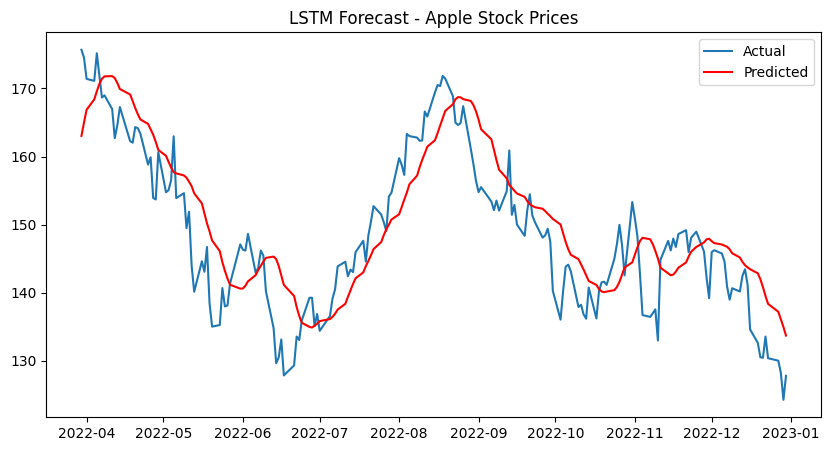

In [21]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(10,5))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(df.index[-len(y_test):], predictions, label="Predicted", color='red')
plt.title("LSTM Forecast - Apple Stock Prices")
plt.legend()
plt.show()


## Evaluation Metrics

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print("MSE:", mse)
print("MAE:", mae)


MSE: 22502.338975187373
MAE: 149.66553533203515


## ✅ Insights:

ARIMA works well for short-term, linear patterns.

LSTM can capture non-linear and long-term dependencies, often performing better on stock prices.

Neither ARIMA nor LSTM can perfectly predict stocks (due to randomness), but they provide useful trends.